In [1]:
import os
import sys
import importlib
from pathlib import Path
from itertools import product
import h5py

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
import skimage.transform

import gym
import mazelab
import torch as th
import torch.nn as nn

from tqdm.auto import tqdm
import imageio
from IPython.display import Image

from stable_baselines3 import A2C
sys.path.insert(1, "../rl-baselines3-zoo")
import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

from captum.attr import IntegratedGradients

In [2]:
########### Set Device ############
# device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device = 'cpu'
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cpu


In [3]:
env_id = "EmptyMaze-10x10-FixedGoal-NonTerminating-v1"
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [7]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=env, device=device)

obs = env.reset()

In [9]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-EmptyMaze-v1-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-EmptyMaze-v1-rollout.gif", width=110, height=110)

In [10]:
obs = env.reset()
for i in range(10):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        break

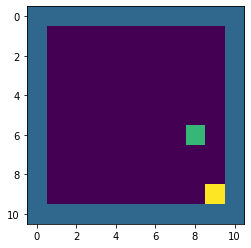

In [11]:
plt.imshow(obs)

# Let's do interpretability on this environment's reward model now.

In [12]:
class RewardModel(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        self.ac_model = A2C('MlpPolicy', env).policy
        self.reward_net = nn.Linear(64, 1).to(device)
        self.device = device

    def forward(self, obs):
        latent, _, _ = self.ac_model._get_latent(th.tensor(obs).to(self.device))
        return self.reward_net(latent)
    
    def tforward(self, obs):
        latent, _, _ = self.ac_model._get_latent(obs)
        return self.reward_net(latent)

    def freeze_extractor(self):
        for p in self.ac_model.policy.features_extractor.parameters():
            p.requires_grad = False

In [13]:
rm = RewardModel(env, 'cpu').to('cpu')
rm.load_state_dict(th.load(f"../reward-models/{env_id}-reward_model.pt", map_location='cpu'))

<All keys matched successfully>

In [14]:
obs = env.reset()
for i in range(20):
    action, _states = model.predict(obs, deterministic=False)
    print(f"pred: {rm(np.expand_dims(obs, axis=0)).item()}")
    obs, reward, done, info = env.step(action)
    print(f"true: {reward}")
    if done:
        break

pred: 0.0009031593799591064
true: -0.01
pred: -0.02158808708190918
true: -0.01
pred: -0.0044119954109191895
true: -0.01
pred: 0.0030315816402435303
true: -0.01
pred: -0.010858520865440369
true: -0.01
pred: -0.011131182312965393
true: -0.01
pred: -0.011429056525230408
true: -0.01
pred: 0.9386224150657654
true: 1.0
pred: -0.014030992984771729
true: -0.01
pred: 0.9386224150657654
true: 1.0
pred: -0.014030992984771729
true: -0.01
pred: 0.9300412535667419
true: 1.0
pred: -0.014030992984771729
true: -0.01
pred: 0.9386224150657654
true: 1.0
pred: -0.014030992984771729
true: -0.01
pred: 0.9386224150657654
true: 1.0
pred: -0.014030992984771729
true: -0.01
pred: 0.9386224150657654
true: 1.0
pred: -0.014030992984771729
true: -0.01
pred: 0.9386224150657654
true: 1.0


# Okay good this reward model appears to be working.

In [66]:
from captum.attr import (
    Saliency,
    IntegratedGradients,
    FeatureAblation,
    FeaturePermutation,
    Occlusion,
    ShapleyValueSampling    
)

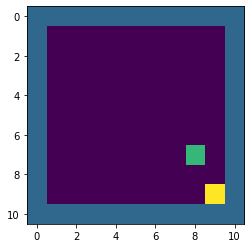

In [16]:
obs = env.reset()
plt.imshow(obs)

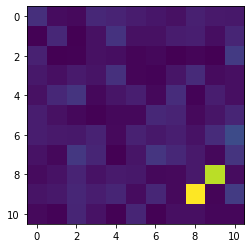

In [17]:
sal = Saliency(rm.tforward)

input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True

attributions = sal.attribute(input)
plt.imshow(attributions.detach()[0, ...])

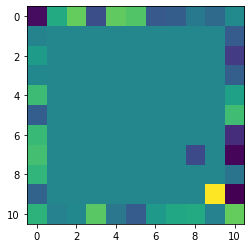

In [18]:
sal = IntegratedGradients(rm.tforward)

input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True

attributions = sal.attribute(input, baselines=-0)
plt.imshow(attributions.detach()[0, ...])

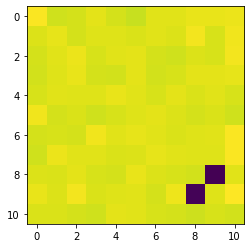

In [50]:
sal = FeatureAblation(rm.tforward)

input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = True

attributions = sal.attribute(input, baselines=2)
plt.imshow(attributions.detach()[0, ...])

In [20]:
sal = FeaturePermutation(rm.tforward)

In [25]:
obss = []

env.reset()
for _ in range(10):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        env.reset()
    obss.append(obs)

obss = np.array(obss)

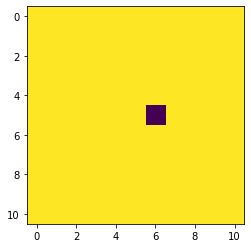

In [39]:
sal = FeaturePermutation(rm.tforward)

input = th.tensor(obss).to('cpu').to(dtype)
input.requires_grad = True

attributions = sal.attribute(input)
plt.imshow(attributions.detach()[0, ...])

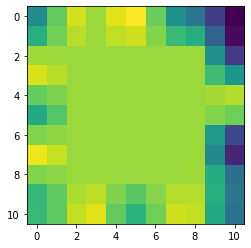

In [60]:
sal = Occlusion(rm.tforward)

input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = False

attributions = sal.attribute(input, sliding_window_shapes=(2,2))
plt.imshow(attributions.detach()[0, ...])

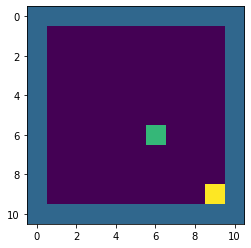

In [70]:
obs = env.reset()
plt.imshow(obs)

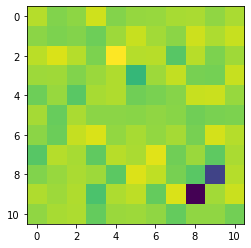

In [74]:
sal = ShapleyValueSampling(rm.tforward)

input = th.tensor(np.expand_dims(obs, axis=0)).to('cpu').to(dtype)
input.requires_grad = False

attributions = sal.attribute(input, baselines=2)
plt.imshow(attributions.detach()[0, ...])

In [13]:
input = th.tensor(np.expand_dims(obs, axis=0).astype(np.float32), requires_grad=True)

ig = IntegratedGradients(rm.forward)
attributions, approximation_error = ig.attribute(input, target=0,
                                    return_convergence_delta=True)

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [41]:
rm(input)

/home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[0.7672]], device='cuda:0', grad_fn=<AddmmBackward>)

In [24]:
rm = rm.to('cpu')

RuntimeError: CUDA error: an illegal memory access was encountered

In [15]:
ig = IntegratedGradients(rm.forward_tensor)

In [18]:
input = th.tensor(np.expand_dims(obs, axis=0).astype(np.float32), requires_grad=True)

In [21]:
ig.attribute(input)

RuntimeError: Function AddmmBackward returned an invalid gradient at index 1 - expected type TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) but got TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt))
Exception raised from validate_outputs at /opt/conda/conda-bld/pytorch_1595629403081/work/torch/csrc/autograd/engine.cpp:622 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x4d (0x7fbf8321677d in /home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x30c5c68 (0x7fbfb8755c68 in /home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #2: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&, std::shared_ptr<torch::autograd::ReadyQueue> const&) + 0x3fd (0x7fbfb875b85d in /home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #3: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&) + 0x451 (0x7fbfb875d401 in /home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #4: torch::autograd::Engine::execute_with_graph_task(std::shared_ptr<torch::autograd::GraphTask> const&, std::shared_ptr<torch::autograd::Node>) + 0x37c (0x7fbfb875ab1c in /home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #5: torch::autograd::python::PythonEngine::execute_with_graph_task(std::shared_ptr<torch::autograd::GraphTask> const&, std::shared_ptr<torch::autograd::Node>) + 0x3c (0x7fbfbca84dcc in /home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #6: torch::autograd::Engine::execute(std::vector<torch::autograd::Edge, std::allocator<torch::autograd::Edge> > const&, std::vector<at::Tensor, std::allocator<at::Tensor> > const&, bool, bool, std::vector<torch::autograd::Edge, std::allocator<torch::autograd::Edge> > const&) + 0x803 (0x7fbfb8759e53 in /home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/torch/lib/libtorch_cpu.so)
frame #7: torch::autograd::python::PythonEngine::execute(std::vector<torch::autograd::Edge, std::allocator<torch::autograd::Edge> > const&, std::vector<at::Tensor, std::allocator<at::Tensor> > const&, bool, bool, std::vector<torch::autograd::Edge, std::allocator<torch::autograd::Edge> > const&) + 0x4e (0x7fbfbca84bbe in /home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #8: THPEngine_run_backward(THPEngine*, _object*, _object*) + 0xa29 (0x7fbfbca85889 in /home/eric/Code/miniconda3/envs/interp/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #9: _PyMethodDef_RawFastCallKeywords + 0x264 (0x55d078db0c94 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #10: _PyMethodDescr_FastCallKeywords + 0x4f (0x55d078db7aef in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #11: _PyEval_EvalFrameDefault + 0x4bac (0x55d078e1c37c in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #12: _PyEval_EvalCodeWithName + 0x2f9 (0x55d078d602b9 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #13: _PyFunction_FastCallKeywords + 0x325 (0x55d078db0435 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #14: _PyEval_EvalFrameDefault + 0x4a59 (0x55d078e1c229 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #15: _PyEval_EvalCodeWithName + 0x2f9 (0x55d078d602b9 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #16: _PyFunction_FastCallDict + 0x400 (0x55d078d61610 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #17: _PyEval_EvalFrameDefault + 0x1d4a (0x55d078e1951a in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #18: _PyEval_EvalCodeWithName + 0xb40 (0x55d078d60b00 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #19: _PyFunction_FastCallKeywords + 0x387 (0x55d078db0497 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #20: _PyEval_EvalFrameDefault + 0x416 (0x55d078e17be6 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #21: _PyEval_EvalCodeWithName + 0xb40 (0x55d078d60b00 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #22: _PyFunction_FastCallKeywords + 0x387 (0x55d078db0497 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #23: _PyEval_EvalFrameDefault + 0x14ea (0x55d078e18cba in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #24: _PyEval_EvalCodeWithName + 0xb40 (0x55d078d60b00 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #25: _PyFunction_FastCallKeywords + 0x387 (0x55d078db0497 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #26: _PyEval_EvalFrameDefault + 0x6a0 (0x55d078e17e70 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #27: _PyEval_EvalCodeWithName + 0x2f9 (0x55d078d602b9 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #28: PyEval_EvalCodeEx + 0x44 (0x55d078d611d4 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #29: PyEval_EvalCode + 0x1c (0x55d078d611fc in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #30: <unknown function> + 0x1dc2ed (0x55d078e272ed in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #31: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x55d078db0b19 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #32: _PyCFunction_FastCallKeywords + 0x21 (0x55d078db0db1 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #33: _PyEval_EvalFrameDefault + 0x46c4 (0x55d078e1be94 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #34: _PyGen_Send + 0x2a2 (0x55d078db8cb2 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #35: _PyEval_EvalFrameDefault + 0x1a87 (0x55d078e19257 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #36: _PyGen_Send + 0x2a2 (0x55d078db8cb2 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #37: _PyEval_EvalFrameDefault + 0x1a87 (0x55d078e19257 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #38: _PyGen_Send + 0x2a2 (0x55d078db8cb2 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #39: _PyMethodDef_RawFastCallKeywords + 0x8d (0x55d078db0abd in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #40: _PyMethodDescr_FastCallKeywords + 0x4f (0x55d078db7aef in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #41: _PyEval_EvalFrameDefault + 0x4bac (0x55d078e1c37c in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #42: _PyFunction_FastCallKeywords + 0xfb (0x55d078db020b in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #43: _PyEval_EvalFrameDefault + 0x416 (0x55d078e17be6 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #44: _PyFunction_FastCallKeywords + 0xfb (0x55d078db020b in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #45: _PyEval_EvalFrameDefault + 0x6a0 (0x55d078e17e70 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #46: _PyEval_EvalCodeWithName + 0x2f9 (0x55d078d602b9 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #47: _PyFunction_FastCallDict + 0x400 (0x55d078d61610 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #48: _PyObject_Call_Prepend + 0x63 (0x55d078d7fb93 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #49: PyObject_Call + 0x6e (0x55d078d7295e in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #50: _PyEval_EvalFrameDefault + 0x1d4a (0x55d078e1951a in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #51: _PyEval_EvalCodeWithName + 0x5da (0x55d078d6059a in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #52: _PyFunction_FastCallKeywords + 0x387 (0x55d078db0497 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #53: _PyEval_EvalFrameDefault + 0x14ea (0x55d078e18cba in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #54: <unknown function> + 0x16d779 (0x55d078db8779 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #55: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x55d078db0b19 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #56: _PyCFunction_FastCallKeywords + 0x21 (0x55d078db0db1 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #57: _PyEval_EvalFrameDefault + 0x46c4 (0x55d078e1be94 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #58: _PyEval_EvalCodeWithName + 0x5da (0x55d078d6059a in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #59: _PyFunction_FastCallKeywords + 0x387 (0x55d078db0497 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #60: _PyEval_EvalFrameDefault + 0x6a0 (0x55d078e17e70 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #61: <unknown function> + 0x16d779 (0x55d078db8779 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #62: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x55d078db0b19 in /home/eric/Code/miniconda3/envs/interp/bin/python)
frame #63: _PyCFunction_FastCallKeywords + 0x21 (0x55d078db0db1 in /home/eric/Code/miniconda3/envs/interp/bin/python)


In [105]:
def rm_eval(obs_t, reward_model):
    latent, _, _= reward_model.ac_model._get_latent(obs_t)
    return reward_model.reward_net(latent)

def get_grad(obs, model):
    obs_t = th.tensor(np.expand_dims(obs, axis=0)).to(device).to(dtype)
    obs_t.requires_grad = True
    reward = rm_eval(obs_t, model)
    reward.backward()
    gradients = obs_t.grad.cpu().detach().numpy().reshape((11, 11))
    return gradients

def int_grad(obs, model, dalpha=0.05, baseline=np.zeros((11, 11))):
    obs_scaled = [obs * alpha for alpha in np.arange(0, 1, dalpha)]
    s = sum([get_grad(obs, model) for obs in obs_scaled]) * dalpha
    IG = (obs - baseline) * s
    return IG

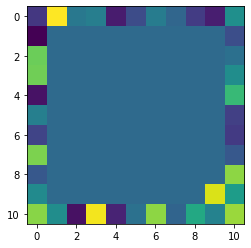

In [106]:
plt.imshow(int_grad(obs, rm, dalpha=0.01))

In [115]:
images = []
for n in tqdm(range(5)):
    obs = env.reset()
    for _ in range(100):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = int_grad(obs, rm, dalpha=0.01)
        frame = 255 * (frame - frame.min()) / (frame.max() - frame.min())
        frame = np.uint8(frame)
        images.append(frame)

imageio.mimsave(f'tmp/rm-EmptyMaze-v0-rollout.gif', images, fps=29)
Image(filename=f"tmp/rm-EmptyMaze-v0-rollout.gif", width=110, height=110)

### Does this pass the random network sanity check?

In [116]:
rm_random = RewardModel(env, device)

In [118]:
images = []
for n in tqdm(range(5)):
    obs = env.reset()
    for _ in range(100):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = int_grad(obs, rm_random, dalpha=0.01)
        frame = 255 * (frame - frame.min()) / (frame.max() - frame.min())
        frame = np.uint8(frame)
        images.append(frame)

imageio.mimsave(f'tmp/rm-random-EmptyMaze-v0-rollout.gif', images, fps=29)
Image(filename=f"tmp/rm-random-EmptyMaze-v0-rollout.gif", width=110, height=110)

### Hmm I'd say that it's not quite passing it. Let's try this whole thing again on another environment.

In [146]:
env_id = "RandomMaze-8x8-FixedGoal-v0"
folder = "../agents"
algo = "ppo"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 1
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

In [147]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1


if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

# env = create_test_env(env_id, n_envs=n_envs,
#                       stats_path=stats_path, seed=seed, log_dir=log_dir,
#                       should_render=not no_render,
#                       hyperparams=hyperparams,
#                       env_kwargs=env_kwargs)

env = gym.make(env_id)
model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

In [148]:
class RewardData(th.utils.data.Dataset):
    def __init__(self, train=True):
        self.f = h5py.File(f"../datasets/rewards_{env_id}.hdf5", 'r')
        if train:
            self.group = self.f['train']
        else:
            self.group = self.f['test']
    
    def __getitem__(self, k):
        input = self.group['inputs'][k]
        output = self.group['outputs'][k]
        return (input, output)
    
    def __len__(self):
        return self.group['inputs'].shape[0]
    
    def close(self):
        self.f.close()
        
class RewardModel(nn.Module):
    """A reward model using an A2C feature extractor"""
    def __init__(self, env, device):
        super(RewardModel, self).__init__()
        self.ac_model = ALGOS['a2c']('MlpPolicy', env).policy
        self.reward_net = nn.Linear(64, 1).to(device)
        self.device = device
    
    def forward(self, obs):
        latent, _, _= self.ac_model._get_latent(th.tensor(obs).to(self.device))
        return self.reward_net(latent)
    
    def freeze_extractor(self):
        for p in self.ac_model.policy.features_extractor.parameters():
            p.requires_grad = False

In [149]:
train = RewardData(train=True)
test = RewardData(train=False)

In [172]:
train_loader = th.utils.data.DataLoader(train, batch_size=20, shuffle=True, num_workers=0)
test_loader = th.utils.data.DataLoader(test, batch_size=20, shuffle=False, num_workers=0)

In [181]:
rm = RewardModel(env, device)

In [182]:
optimizer = th.optim.Adam(rm.parameters())
loss_fn = th.nn.MSELoss(reduction="sum")

In [187]:
num_batches = 0
for _ in tqdm(range(4)):
    for samples, targets in train_loader:
        optimizer.zero_grad()
        batch_loss = loss_fn(rm(samples), targets.to(device))
        batch_loss.backward()
        optimizer.step()
        num_batches += 1
    print(batch_loss)

/home/eric/Code/miniconda3/envs/interp2/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(1.0857, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.2137, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.6918, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward>)



In [188]:
obss, rewards = next(iter(test_loader))
print(rm(obss), "\n", rewards)

tensor([[-3.2496e-02],
        [ 1.1394e-01],
        [-1.5740e-02],
        [ 2.4436e-01],
        [ 8.8173e+00],
        [-3.5560e-02],
        [-2.6119e-02],
        [ 2.2836e-01],
        [ 2.3311e-01],
        [ 1.0169e+01],
        [-4.2784e-03],
        [-1.0384e+00],
        [-9.2043e-02],
        [-6.8703e-01],
        [-4.7557e-02],
        [ 1.5552e-01],
        [-8.1366e-02],
        [-3.1277e-02],
        [ 5.8953e+00],
        [ 6.9070e-01]], device='cuda:0', grad_fn=<AddmmBackward>) 
 tensor([[-1.0000e-02],
        [-1.0000e-02],
        [-1.0000e-02],
        [-1.0000e-02],
        [ 1.0000e+01],
        [-1.0000e-01],
        [-1.0000e-02],
        [-1.0000e-02],
        [-1.0000e-02],
        [ 1.0000e+01],
        [-1.0000e-01],
        [-1.0000e-02],
        [-1.0000e-02],
        [-1.0000e-02],
        [-1.0000e-02],
        [-1.0000e-02],
        [-1.0000e-02],
        [-1.0000e-02],
        [ 1.0000e+01],
        [-1.0000e-01]])


/home/eric/Code/miniconda3/envs/interp2/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [190]:
def rm_eval(obs_t, reward_model):
    latent, _, _= reward_model.ac_model._get_latent(obs_t)
    return reward_model.reward_net(latent)

def get_grad(obs, model):
    obs_t = th.tensor(np.expand_dims(obs, axis=0)).to(device).to(dtype)
    obs_t.requires_grad = True
    reward = rm_eval(obs_t, model)
    reward.backward()
    gradients = obs_t.grad.cpu().detach().numpy().reshape((9, 9))
    return gradients

def int_grad(obs, model, dalpha=0.05, baseline=np.zeros((9, 9))):
    obs_scaled = [obs * alpha for alpha in np.arange(0, 1, dalpha)]
    s = sum([get_grad(obs, model) for obs in obs_scaled]) * dalpha
    IG = (obs - baseline) * s
    return IG

In [194]:
images = []
for n in tqdm(range(15)):
    obs = env.reset()
    for _ in range(20):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = int_grad(obs, rm, dalpha=0.01)
        frame = 255 * (frame - frame.min()) / (frame.max() - frame.min())
        frame = np.uint8(frame)
        images.append(frame)

imageio.mimsave(f'tmp/rm-EmptyMaze-v0-rollout.gif', images, fps=29)
Image(filename=f"tmp/rm-EmptyMaze-v0-rollout.gif", width=110, height=110)

### What does a random network look like?

In [195]:
rm_random = RewardModel(env, device)

In [196]:
images = []
for n in tqdm(range(15)):
    obs = env.reset()
    for _ in range(20):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = int_grad(obs, rm_random, dalpha=0.01)
        frame = 255 * (frame - frame.min()) / (frame.max() - frame.min())
        frame = np.uint8(frame)
        images.append(frame)

imageio.mimsave(f'tmp/rm-random-EmptyMaze-v0-rollout.gif', images, fps=29)
Image(filename=f"tmp/rm-random-EmptyMaze-v0-rollout.gif", width=110, height=110)

# Okay so it looks like the agent position is most salient, and we are sort of passing the sanity check. However, it appears that the agent position isn't the only thing that's salient, and so the saliency map isn't necessarily more interpretable for reward functions than for policies

# Let's look at a AIRL reward model now

In [5]:
device = 'cpu'

In [8]:
discrim = th.load('../../imitation/output/train_adversarial/mazelab:EmptyMaze-10x10-FixedGoal-NonTerminating-v0/20200801_154433_fc0f5d/checkpoints/final/discrim.pt', map_location=device)
model = ALGOS['ppo'].load('../agents/ppo/EmptyMaze-10x10-FixedGoal-NonTerminating-v0_1/best_model.zip')

env = gym.make('EmptyMaze-10x10-FixedGoal-NonTerminating-v0')

In [11]:
images = []
for n in range(30):
    obs = env.reset()
    for _ in range(1000):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = env.get_image()
        images.append(frame)

imageio.mimsave(f'tmp/PPO-EmptyMaze-v0-rollout.gif', images, fps=29)
Image(filename=f"tmp/PPO-EmptyMaze-v0-rollout.gif", width=110, height=110)

In [12]:
obs = env.reset()
for _ in range(15):
    obs_prev = obs
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    state = np.expand_dims(obs_prev, axis=0)
    next_state = np.expand_dims(obs, axis=0)
    print(discrim.predict_reward_test(state, np.array([action]), next_state, done=done))
    if done:
        break

[-14.943096]
[-13.898671]
[-14.300656]
[-14.3969555]
[-14.016666]
[-14.145714]
[-14.821103]
[-14.36621]
[-13.680828]
[-13.9513035]
[-15.130604]
[-13.9513035]
[-15.130604]
[-14.188853]
[-15.130604]


In [13]:
obs = env.reset()
for _ in range(15):
    obs_prev = obs
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    state = np.expand_dims(obs_prev, axis=0)
    state = th.tensor(state).to(dtype)
#     state = obs_prev
#     state = th.tensor(state)
    next_state = np.expand_dims(obs, axis=0)
    next_state = th.tensor(next_state).to(dtype)
#     next_state = 
#     next_state = obs
    next_state = th.tensor(next_state)
    reward = discrim.reward_net.reward_test(state, th.tensor(np.array([action])), next_state, done=done)
    print(reward)
    if done:
        break

tensor([-15.0444], grad_fn=<SqueezeBackward1>)
tensor([-14.9065], grad_fn=<SqueezeBackward1>)
tensor([-13.8714], grad_fn=<SqueezeBackward1>)
tensor([-14.1148], grad_fn=<SqueezeBackward1>)
tensor([-13.7833], grad_fn=<SqueezeBackward1>)
tensor([-13.9063], grad_fn=<SqueezeBackward1>)
tensor([-14.2904], grad_fn=<SqueezeBackward1>)
tensor([-14.0530], grad_fn=<SqueezeBackward1>)
tensor([-14.1806], grad_fn=<SqueezeBackward1>)
tensor([-13.9458], grad_fn=<SqueezeBackward1>)
tensor([-14.0062], grad_fn=<SqueezeBackward1>)
tensor([-14.1457], grad_fn=<SqueezeBackward1>)
tensor([-14.8211], grad_fn=<SqueezeBackward1>)
tensor([-14.3662], grad_fn=<SqueezeBackward1>)
tensor([-13.6808], grad_fn=<SqueezeBackward1>)


/home/eric/Code/miniconda3/envs/interp2/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [14]:
def get_grad(obs, model):
    obs_t = th.tensor(np.expand_dims(obs, axis=0)).to(device).to(dtype)
    action = th.tensor(np.array([0]))
    next_state = th.tensor(np.random.randn(1, 11, 11)).to(dtype)
    obs_t.requires_grad = True
    reward = model.reward_net.reward_test(obs_t, action, next_state, done=done)
    reward.backward()
    gradients = obs_t.grad.cpu().detach().numpy().reshape((11, 11))
    return gradients

def int_grad(obs, model, dalpha=0.05, baseline=np.zeros((11, 11))):
    obs_scaled = [obs * alpha for alpha in np.arange(0, 1, dalpha)]
    s = sum([get_grad(obs, model) for obs in obs_scaled]) * dalpha
    IG = (obs - baseline) * s
    return IG

In [15]:
obs = env.reset()

In [16]:
obs_t = th.tensor(np.expand_dims(obs, axis=0)).to(device).to(dtype)
action = th.tensor(np.array([0]))
next_state = th.tensor(np.random.randn(1, 11, 11)).to(dtype)
obs_t.requires_grad = True

In [17]:
reward = discrim.reward_net.reward_test(obs_t, action, next_state, done=done)

In [18]:
reward.backward()

In [28]:
images = []
for n in tqdm(range(15)):
    obs = env.reset()
    for _ in range(20):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = int_grad(obs, discrim, dalpha=0.01)
        frame = 255 * (frame - frame.min()) / (frame.max() - frame.min())
        frame = np.uint8(frame)
        images.append(frame)

imageio.mimsave(f'tmp/rm-airl-EmptyMaze-v0-rollout.gif', images, fps=29)
Image(filename=f"tmp/rm-airl-EmptyMaze-v0-rollout.gif", width=110, height=110)

In [35]:
from imitation.rewards.discrim_net import DiscrimNetAIRL
from imitation.rewards.reward_net import BasicShapedRewardNet

In [54]:
reward_net = BasicShapedRewardNet(env.observation_space, env.action_space, use_action=False, use_next_state=False)
discrim = DiscrimNetAIRL(reward_net=reward_net)


In [55]:
def get_grad(obs, model):
    obs_t = th.tensor(np.expand_dims(obs, axis=0)).to(device).to(dtype)
    action = th.tensor(np.array([[0]]))
    next_state = th.tensor(np.random.randn(1, 11, 11)).to(dtype)
    obs_t.requires_grad = True
    reward = model.reward_net.reward_test(obs_t, action, next_state, done=done)
    reward.backward()
    gradients = obs_t.grad.cpu().detach().numpy().reshape((11, 11))
    return gradients

def int_grad(obs, model, dalpha=0.05, baseline=np.zeros((11, 11))):
    obs_scaled = [obs * alpha for alpha in np.arange(0, 1, dalpha)]
    s = sum([get_grad(obs, model) for obs in obs_scaled]) * dalpha
    IG = (obs - baseline) * s
    return IG

In [56]:
images = []
for n in tqdm(range(15)):
    obs = env.reset()
    for _ in range(20):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        frame = int_grad(obs, discrim, dalpha=0.01)
        frame = 255 * (frame - frame.min()) / (frame.max() - frame.min())
        frame = np.uint8(frame)
        images.append(frame)

imageio.mimsave(f'tmp/rm-random-EmptyMaze-v0-rollout.gif', images, fps=29)
Image(filename=f"tmp/rm-random-EmptyMaze-v0-rollout.gif", width=110, height=110)